## ECG Heartbeat Categorization Machine Learning

In [47]:
# Initialize libaries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from model_definitions import stanford_resnet
from data_processing import load_data

from collections import Counter

Load in ECG Heartbeat Categorization Datasets
   - The final element of each row denotes which class that samples belongs
   - Samples are padded with zeros at the end to normalize sample sizes

In [2]:
# Loading data in through Pandas, faster than numpy for dataset of this size
data1 = pd.read_csv("./archive/mitbih_train.csv", header=None) # 5 Categories, 125Hz, 109446 Samples

# Separate final column and save as labels
data1_labels = data1.pop(len(data1.columns)-1)

# Convert to numpy - Faster than just loading in directly with numpy for this dataset size
data1 = data1.to_numpy()

data1_labels = data1_labels.to_numpy()

print(data1.shape)

(87554, 187)


Now that the data is separated, start with some analysis.

    - N: Normal Beat
    - S: Supraventricular premature beat
    - V: Premature ventricular contraction
    - F: Fusion of ventricular and normal beat
    - Q: Unclassifiable beat

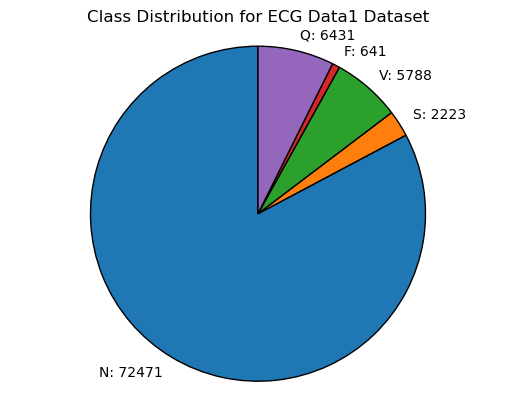

In [3]:
# Check class balance
classes = {0:'N', 1:'S', 2:'V', 3:'F', 4:'Q'}

class_counts = Counter(data1_labels)
sizes = []
labels = []
for key in class_counts:
    sizes.append(class_counts[key])
    labels.append(classes[key]+": "+"{}".format(class_counts[key]))
    
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, startangle=90,
        wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Class Distribution for ECG Data1 Dataset')
plt.show()

Normal Heartbeats are represented much higher in the dataset than the other classes. Typically, class balance is important to make sure the model does not get too biased towards classifying the majority class. There are a few different ways to implement this balance.

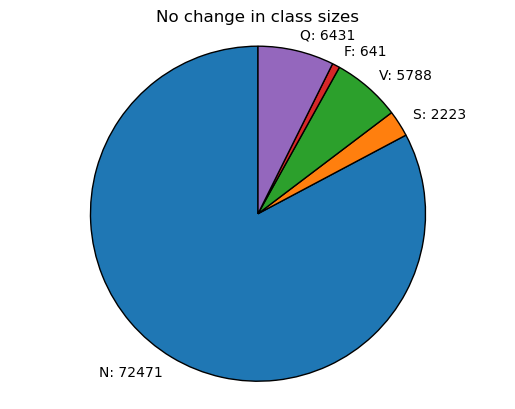

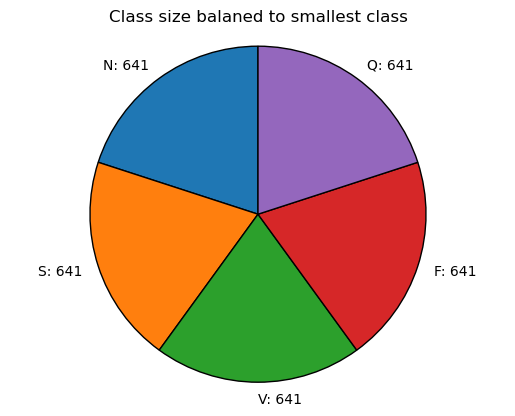

In [4]:
# No change in class sizes
# data1, data1_labels remain unchanged
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, startangle=90,
        wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('No change in class sizes')
plt.show()

# Class sizes limited to size of smallest class
lowest = class_counts[min(class_counts, key=class_counts.get)]
data1_reduced = np.empty((0,data1.shape[1]))
data1_labels_reduced = np.empty((0))
for label in np.unique(data1_labels):
    label_indices = np.where(data1_labels==label)
    label_indices_reduced = np.random.choice(label_indices[0], lowest, replace=False)
    
    temp_data     = data1[label_indices_reduced]
    temp_labels   = data1_labels[label_indices_reduced]
    data1_reduced = np.append(data1_reduced, temp_data, axis=0)
    data1_labels_reduced = np.append(data1_labels_reduced, temp_labels, axis=0)

class_counts1 = Counter(data1_labels_reduced)
sizes1  = []
labels1 = []
for key in class_counts1:
    sizes1.append(class_counts1[key])
    labels1.append(classes[key]+": "+"{}".format(class_counts1[key]))
    
fig2, ax2 = plt.subplots()
ax2.pie(sizes1, labels=labels1, startangle=90,
        wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True})
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Class size balaned to smallest class')
plt.show()


Now that there are a few different sets of data available for training, load in the machine learning model and begin training.

In [17]:
# Load in model
input_shape = (187,1) # Number of channels per input is 1
num_classes = len(np.unique(data1_labels))
num_blocks  = 3

model = stanford_resnet(input_shape, num_classes, 3)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 conv1d_9 (Conv1D)              (None, 187, 32)      192         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 187, 32)     128         ['conv1d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 187, 32)      0           ['batch_normalization_9[0][

 batch_normalization_16 (BatchN  (None, 187, 32)     128         ['conv1d_16[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_16 (Activation)     (None, 187, 32)      0           ['batch_normalization_16[0][0]'] 
                                                                                                  
 dropout_13 (Dropout)           (None, 187, 32)      0           ['activation_16[0][0]']          
                                                                                                  
 conv1d_17 (Conv1D)             (None, 187, 32)      5152        ['dropout_13[0][0]']             
                                                                                                  
 max_pooling1d_7 (MaxPooling1D)  (None, 187, 32)     0           ['add_6[0][0]']                  
          

C:\Users\donki\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [24]:
# Train model on first configuration
if not os.path.exists('./model1/'):
    os.makedirs('./model1/')

X = np.expand_dims(data1, axis=2)
y = tf.keras.utils.to_categorical(data1_labels, num_classes=5, dtype='int')

# Split data into Train/Validation/Test sets [80/10/10]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test     = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

# Train model
checkpoint_path = './model1/model.{epoch:02d}-{val_loss:.2f}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                               save_weights_only=False,
                                                               monitor='val_accuracy')
history = model.fit(X_train, y_train,
                    batch_size=32, epochs=10,
                    validation_data=(X_val, y_val),
                    callbacks=[model_checkpoint_callback])
model.save('./model1/final_model')


# Save history of training
history_dict = history.history
with open('./model1/history.pkl', 'wb') as handle:
    pickle.dump(history_dict, handle)
    
# Create Acc and Loss plots
plt.figure()
plt.plot(history_dict['loss'])
plt.title('Training Loss')
plt.savefig('./model1/Loss_Plot.png')
plt.show()

plt.figure()
plt.plot(history_dict['accuracy'])
plt.title('Training Acc')
plt.savefig('./model1/Acc_Plot.png')
plt.show()

Epoch 1/10
2189/2189 [==============================] - ETA: 0s - loss: 0.1156 - accuracy: 0.9681

INFO:tensorflow:Assets written to: ./model1\model.01-0.09\assets


INFO:tensorflow:Assets written to: ./model1\model.01-0.09\assets


2189/2189 [==============================] - 164s 75ms/step - loss: 0.1156 - accuracy: 0.9681 - val_loss: 0.0931 - val_accuracy: 0.9734
Epoch 2/10
2189/2189 [==============================] - ETA: 0s - loss: 0.1000 - accuracy: 0.9720

INFO:tensorflow:Assets written to: ./model1\model.02-0.11\assets


INFO:tensorflow:Assets written to: ./model1\model.02-0.11\assets


2189/2189 [==============================] - 168s 77ms/step - loss: 0.1000 - accuracy: 0.9720 - val_loss: 0.1125 - val_accuracy: 0.9701
Epoch 3/10
2189/2189 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.9750

INFO:tensorflow:Assets written to: ./model1\model.03-0.12\assets


INFO:tensorflow:Assets written to: ./model1\model.03-0.12\assets


2189/2189 [==============================] - 168s 77ms/step - loss: 0.0888 - accuracy: 0.9750 - val_loss: 0.1167 - val_accuracy: 0.9665
Epoch 4/10
2189/2189 [==============================] - ETA: 0s - loss: 0.0833 - accuracy: 0.9763

INFO:tensorflow:Assets written to: ./model1\model.04-0.10\assets


INFO:tensorflow:Assets written to: ./model1\model.04-0.10\assets


2189/2189 [==============================] - 171s 78ms/step - loss: 0.0833 - accuracy: 0.9763 - val_loss: 0.1007 - val_accuracy: 0.9726
Epoch 5/10
2189/2189 [==============================] - ETA: 0s - loss: 0.0771 - accuracy: 0.9778

INFO:tensorflow:Assets written to: ./model1\model.05-0.09\assets


INFO:tensorflow:Assets written to: ./model1\model.05-0.09\assets


2189/2189 [==============================] - 173s 79ms/step - loss: 0.0771 - accuracy: 0.9778 - val_loss: 0.0865 - val_accuracy: 0.9744
Epoch 6/10
2189/2189 [==============================] - ETA: 0s - loss: 0.0728 - accuracy: 0.9783

INFO:tensorflow:Assets written to: ./model1\model.06-0.08\assets


INFO:tensorflow:Assets written to: ./model1\model.06-0.08\assets


2189/2189 [==============================] - 176s 80ms/step - loss: 0.0728 - accuracy: 0.9783 - val_loss: 0.0777 - val_accuracy: 0.9793
Epoch 7/10
2189/2189 [==============================] - ETA: 0s - loss: 0.0679 - accuracy: 0.9800

INFO:tensorflow:Assets written to: ./model1\model.07-0.08\assets


INFO:tensorflow:Assets written to: ./model1\model.07-0.08\assets


2189/2189 [==============================] - 158s 72ms/step - loss: 0.0679 - accuracy: 0.9800 - val_loss: 0.0829 - val_accuracy: 0.9761
Epoch 8/10
2189/2189 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9807

INFO:tensorflow:Assets written to: ./model1\model.08-0.08\assets


INFO:tensorflow:Assets written to: ./model1\model.08-0.08\assets


2189/2189 [==============================] - 159s 73ms/step - loss: 0.0651 - accuracy: 0.9807 - val_loss: 0.0779 - val_accuracy: 0.9791
Epoch 9/10
2189/2189 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9815

INFO:tensorflow:Assets written to: ./model1\model.09-0.07\assets


INFO:tensorflow:Assets written to: ./model1\model.09-0.07\assets


2189/2189 [==============================] - 155s 71ms/step - loss: 0.0610 - accuracy: 0.9815 - val_loss: 0.0698 - val_accuracy: 0.9816
Epoch 10/10
2189/2189 [==============================] - ETA: 0s - loss: 0.0599 - accuracy: 0.9820

INFO:tensorflow:Assets written to: ./model1\model.10-0.07\assets


INFO:tensorflow:Assets written to: ./model1\model.10-0.07\assets


2189/2189 [==============================] - 158s 72ms/step - loss: 0.0599 - accuracy: 0.9820 - val_loss: 0.0689 - val_accuracy: 0.9809


Now that the model has been trained, take a look at how well it performs against initial test data.

In [46]:
# Get accuracy against the saved test set
performance = model.evaluate(X_test, y_test)
print('Test Loss: {:.2f} | Test Acc: {:.2f}'.format(performance[0], performance[1]))

274/274 [==============================] - 3s 11ms/step - loss: 0.0702 - accuracy: 0.9791
Test Loss: 0.07 | Test Acc: 0.98


Performance seems relatively good. Now check model performance against a full set of test cases.

In [50]:
new_data, new_labels = load_data("./archive/mitbih_test.csv")
new_data = np.expand_dims(new_data, axis=2)

predictions = model.predict(new_data)
model_preds = []
for prediction in predictions:
    model_preds.append(np.argmax(prediction))

685/685 [==============================] - 7s 10ms/step


<class 'numpy.ndarray'>
[18118.   556.  1448.   162.  1608.]
[[17955    77    57     7    22]
 [  131   409    12     2     2]
 [   58     5  1371    11     3]
 [   28     0    22   112     0]
 [   16     1     5     0  1586]]


C:\Users\donki\AppData\Local\Temp\ipykernel_16704\3994579594.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
C:\Users\donki\AppData\Local\Temp\ipykernel_16704\3994579594.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)
C:\Users\donki\AppData\Local\Temp\ipykernel_16704\3994579594.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
C:\Users\donki\AppData\Local\Temp\ipykernel_16704\3994579594.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


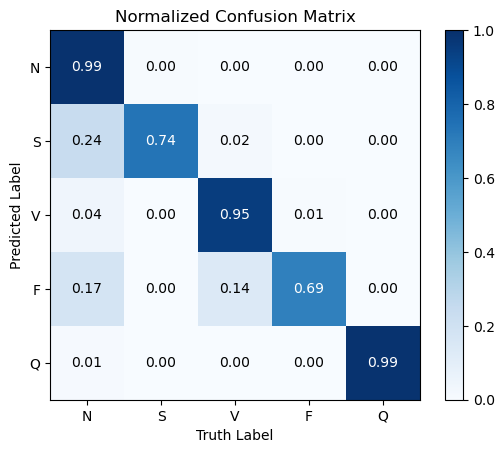

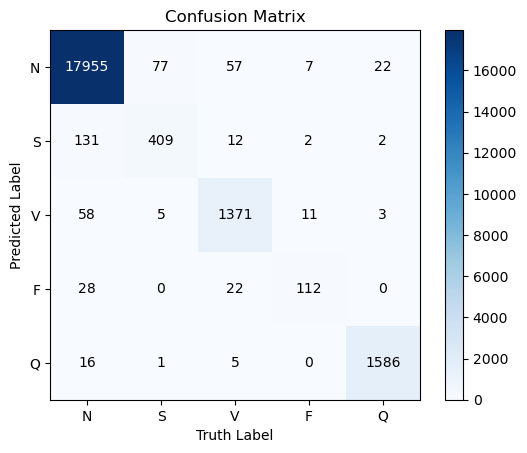

In [82]:
# Get confusion matrix of the results. 
cm = confusion_matrix(new_labels, model_preds)
cm_norm = cm / cm.astype(float).sum(axis=1)[:,np.newaxis]

# Plot Normalized Confusion Matrix
fig, ax = plt.subplots()
cax = ax.matshow(cm_norm, cmap='Blues', vmin=0, vmax=1)
for (i,j), z in np.ndenumerate(cm_norm):
    if z > 0.5:
        ax.text(j, i, '{:.2f}'.format(z), ha='center', va='center', color='w')
    else:
        ax.text(j, i, '{:.2f}'.format(z), ha='center', va='center')
fig.colorbar(cax)
labels = ['','N','S','V','F','Q']

ax.set_title('Normalized Confusion Matrix')
ax.set_xlabel('Truth Label')
ax.set_ylabel('Predicted Label')

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.xaxis.set_ticks_position('bottom')

fig.savefig('./model1/Normalized_Confusion_Matrix.png')

# Plot Confusion Matrix
cm_max = np.max(cm)
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap='Blues')
for (i,j), z in np.ndenumerate(cm):
    if z > cm_max/2:
        ax.text(j, i, '{:.0f}'.format(z), ha='center', va='center', color='w')
    else:
        ax.text(j, i, '{:.0f}'.format(z), ha='center', va='center')
fig.colorbar(cax)
labels = ['','N','S','V','F','Q']

ax.set_title('Confusion Matrix')
ax.set_xlabel('Truth Label')
ax.set_ylabel('Predicted Label')

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.xaxis.set_ticks_position('bottom')

fig.savefig('./model1/Confusion_Matrix.png')

Overall classification rate seems to be doing well, but performace is particularly poor for classes S and F (Supraventricular Premature Beat and Fusion of Ventricular and Normal beat), which also happen to be the two smallest classes in the dataset. 

Now check performance when training against a balanced dataset.

In [83]:
# Load in model
input_shape = (187,1) # Number of channels per input is 1
num_classes = len(np.unique(data1_labels))
num_blocks  = 3

model = stanford_resnet(input_shape, num_classes, 3)
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 conv1d_18 (Conv1D)             (None, 187, 32)      192         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_18 (BatchN  (None, 187, 32)     128         ['conv1d_18[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_18 (Activation)     (None, 187, 32)      0           ['batch_normalization_18[0]

                                                                                                  
 batch_normalization_25 (BatchN  (None, 187, 32)     128         ['conv1d_25[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_25 (Activation)     (None, 187, 32)      0           ['batch_normalization_25[0][0]'] 
                                                                                                  
 dropout_20 (Dropout)           (None, 187, 32)      0           ['activation_25[0][0]']          
                                                                                                  
 conv1d_26 (Conv1D)             (None, 187, 32)      5152        ['dropout_20[0][0]']             
                                                                                                  
 max_pooli

C:\Users\donki\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
80/81 [============================>.] - ETA: 0s - loss: 2.4355 - accuracy: 0.5953

INFO:tensorflow:Assets written to: ./model2\model.01-4.98\assets


INFO:tensorflow:Assets written to: ./model2\model.01-4.98\assets


81/81 [==============================] - 13s 160ms/step - loss: 2.4328 - accuracy: 0.5956 - val_loss: 4.9816 - val_accuracy: 0.4281
Epoch 2/10
80/81 [============================>.] - ETA: 0s - loss: 0.6854 - accuracy: 0.7559

INFO:tensorflow:Assets written to: ./model2\model.02-0.88\assets


INFO:tensorflow:Assets written to: ./model2\model.02-0.88\assets


81/81 [==============================] - 12s 147ms/step - loss: 0.6844 - accuracy: 0.7562 - val_loss: 0.8800 - val_accuracy: 0.6938
Epoch 3/10
80/81 [============================>.] - ETA: 0s - loss: 0.5462 - accuracy: 0.7945

INFO:tensorflow:Assets written to: ./model2\model.03-0.51\assets


INFO:tensorflow:Assets written to: ./model2\model.03-0.51\assets


81/81 [==============================] - 12s 148ms/step - loss: 0.5463 - accuracy: 0.7945 - val_loss: 0.5073 - val_accuracy: 0.7781
Epoch 4/10
80/81 [============================>.] - ETA: 0s - loss: 0.4869 - accuracy: 0.8164

INFO:tensorflow:Assets written to: ./model2\model.04-0.49\assets


INFO:tensorflow:Assets written to: ./model2\model.04-0.49\assets


81/81 [==============================] - 12s 153ms/step - loss: 0.4868 - accuracy: 0.8163 - val_loss: 0.4910 - val_accuracy: 0.7937
Epoch 5/10
80/81 [============================>.] - ETA: 0s - loss: 0.4397 - accuracy: 0.8344

INFO:tensorflow:Assets written to: ./model2\model.05-0.49\assets


INFO:tensorflow:Assets written to: ./model2\model.05-0.49\assets


81/81 [==============================] - 12s 153ms/step - loss: 0.4392 - accuracy: 0.8346 - val_loss: 0.4910 - val_accuracy: 0.8000
Epoch 6/10
80/81 [============================>.] - ETA: 0s - loss: 0.3937 - accuracy: 0.8562

INFO:tensorflow:Assets written to: ./model2\model.06-0.48\assets


INFO:tensorflow:Assets written to: ./model2\model.06-0.48\assets


81/81 [==============================] - 13s 162ms/step - loss: 0.3936 - accuracy: 0.8561 - val_loss: 0.4769 - val_accuracy: 0.8031
Epoch 7/10
80/81 [============================>.] - ETA: 0s - loss: 0.3492 - accuracy: 0.8668

INFO:tensorflow:Assets written to: ./model2\model.07-0.48\assets


INFO:tensorflow:Assets written to: ./model2\model.07-0.48\assets


81/81 [==============================] - 12s 152ms/step - loss: 0.3488 - accuracy: 0.8670 - val_loss: 0.4816 - val_accuracy: 0.8156
Epoch 8/10
80/81 [============================>.] - ETA: 0s - loss: 0.3465 - accuracy: 0.8695

INFO:tensorflow:Assets written to: ./model2\model.08-0.42\assets


INFO:tensorflow:Assets written to: ./model2\model.08-0.42\assets


81/81 [==============================] - 12s 153ms/step - loss: 0.3461 - accuracy: 0.8697 - val_loss: 0.4160 - val_accuracy: 0.8438
Epoch 9/10
80/81 [============================>.] - ETA: 0s - loss: 0.3007 - accuracy: 0.8855

INFO:tensorflow:Assets written to: ./model2\model.09-0.38\assets


INFO:tensorflow:Assets written to: ./model2\model.09-0.38\assets


81/81 [==============================] - 12s 146ms/step - loss: 0.3004 - accuracy: 0.8857 - val_loss: 0.3813 - val_accuracy: 0.8656
Epoch 10/10
80/81 [============================>.] - ETA: 0s - loss: 0.3059 - accuracy: 0.8848

INFO:tensorflow:Assets written to: ./model2\model.10-0.46\assets


INFO:tensorflow:Assets written to: ./model2\model.10-0.46\assets


81/81 [==============================] - 13s 159ms/step - loss: 0.3058 - accuracy: 0.8846 - val_loss: 0.4587 - val_accuracy: 0.8438


INFO:tensorflow:Assets written to: ./model2/final_model\assets


INFO:tensorflow:Assets written to: ./model2/final_model\assets


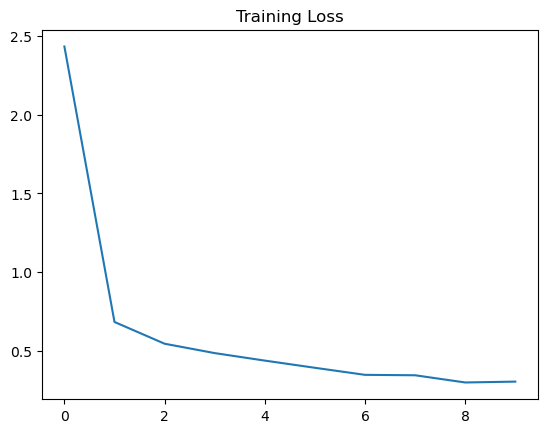

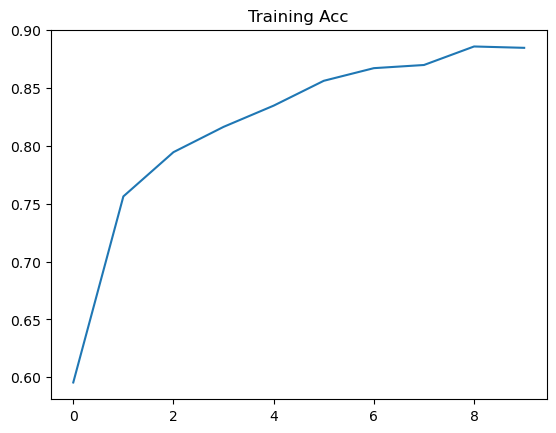

In [93]:
# Train model on second configuration
filepath = './model2/'
if not os.path.exists(filepath):
    os.makedirs(filepath)

X = np.expand_dims(data1_reduced, axis=2)
y = tf.keras.utils.to_categorical(data1_labels_reduced, num_classes=5, dtype='int')

# Split data into Train/Validation/Test sets [80/10/10]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test     = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

# Train model
checkpoint_path = filepath+'model.{epoch:02d}-{val_loss:.2f}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                               save_weights_only=False,
                                                               monitor='val_accuracy')
history = model.fit(X_train, y_train,
                    batch_size=32, epochs=10,
                    validation_data=(X_val, y_val),
                    callbacks=[model_checkpoint_callback])
model.save(filepath+'final_model')


# Save history of training
history_dict = history.history
with open(filepath+'history.pkl', 'wb') as handle:
    pickle.dump(history_dict, handle)
    
# Create Acc and Loss plots
plt.figure()
plt.plot(history_dict['loss'])
plt.title('Training Loss')
plt.savefig(filepath+'Loss_Plot.png')
plt.show()

plt.figure()
plt.plot(history_dict['accuracy'])
plt.title('Training Acc')
plt.savefig(filepath+'Acc_Plot.png')
plt.show()

Performance currently looks a little worse than the first set of data.

In [94]:
# Get accuracy against the saved test set
performance = model.evaluate(X_test, y_test)
print('Test Loss: {:.2f} | Test Acc: {:.2f}'.format(performance[0], performance[1]))

11/11 [==============================] - 0s 17ms/step - loss: 0.5117 - accuracy: 0.7944
Test Loss: 0.51 | Test Acc: 0.79


Test split data is also not performancing as well.

In [95]:
new_data, new_labels = load_data("./archive/mitbih_test.csv")
new_data = np.expand_dims(new_data, axis=2)

predictions = model.predict(new_data)
model_preds = []
for prediction in predictions:
    model_preds.append(np.argmax(prediction))

685/685 [==============================] - 10s 14ms/step


C:\Users\donki\AppData\Local\Temp\ipykernel_16704\1768908048.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
C:\Users\donki\AppData\Local\Temp\ipykernel_16704\1768908048.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)
C:\Users\donki\AppData\Local\Temp\ipykernel_16704\1768908048.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
C:\Users\donki\AppData\Local\Temp\ipykernel_16704\1768908048.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


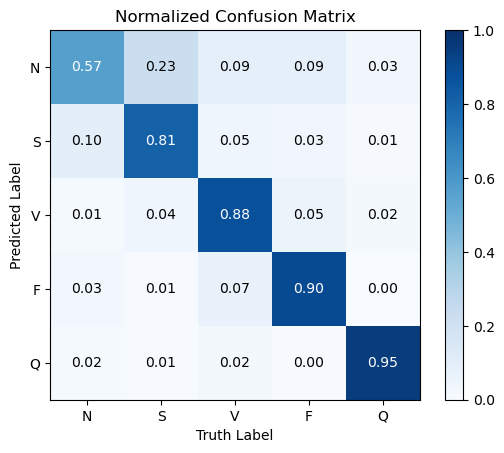

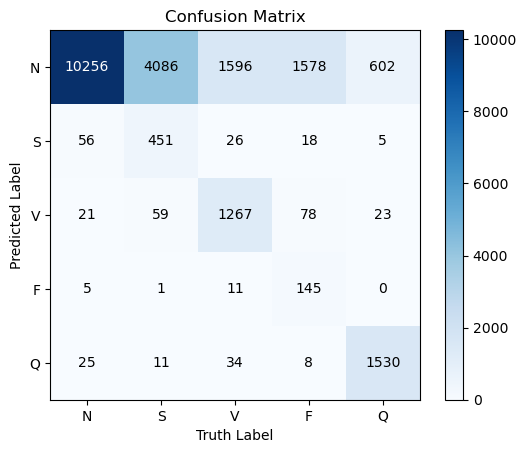

In [96]:
# Get confusion matrix of the results. 
cm = confusion_matrix(new_labels, model_preds)
cm_norm = cm / cm.astype(float).sum(axis=1)[:,np.newaxis]

# Plot Normalized Confusion Matrix
fig, ax = plt.subplots()
cax = ax.matshow(cm_norm, cmap='Blues', vmin=0, vmax=1)
for (i,j), z in np.ndenumerate(cm_norm):
    if z > 0.5:
        ax.text(j, i, '{:.2f}'.format(z), ha='center', va='center', color='w')
    else:
        ax.text(j, i, '{:.2f}'.format(z), ha='center', va='center')
fig.colorbar(cax)
labels = ['','N','S','V','F','Q']

ax.set_title('Normalized Confusion Matrix')
ax.set_xlabel('Truth Label')
ax.set_ylabel('Predicted Label')

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.xaxis.set_ticks_position('bottom')

fig.savefig(filepath+'Normalized_Confusion_Matrix.png')

# Plot Confusion Matrix
cm_max = np.max(cm)
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap='Blues')
for (i,j), z in np.ndenumerate(cm):
    if z > cm_max/2:
        ax.text(j, i, '{:.0f}'.format(z), ha='center', va='center', color='w')
    else:
        ax.text(j, i, '{:.0f}'.format(z), ha='center', va='center')
fig.colorbar(cax)
labels = ['','N','S','V','F','Q']

ax.set_title('Confusion Matrix')
ax.set_xlabel('Truth Label')
ax.set_ylabel('Predicted Label')

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.xaxis.set_ticks_position('bottom')

fig.savefig(filepath+'Confusion_Matrix.png')

The performance of the model against the balanced dataset has a more even performance against the smaller classes, but the performance against the Normal class is much worse.

Given the nature of this problem, the performance of this model might actually be preferrable. (Normal heartbeats classified as anomalous heartbeats is preferrable to classifying an anomalous heartbeat as a normal one)  but an ideal case would have improved performance across all classes.

It would appear that a better solution could be found by choosing a better dataset balance.
